In [ ]:
# https://www.kaggle.com/rcushen/topic-modelling-with-lsa-and-lda 참고
# 데이터셋도 제공됨.

'''
LSA와 LSA 파악

Q. Great analysis! I wonder what is causing this big a difference between LSA and LDA, but I suppose that's really deep in the weeds.
A. I wondered the same! My best guess is that it's a combination of the short string lengths of each document and the different techniques that underlie LSA and LDA.
I think the expectation maximisation algorithm for the latter is able to almost perfectly homogenise the distribution of topics (which you can see in one of the charts) in a way that I don't imagine would be possible for larger documents with more variability.
Meanwhile the matrix decomposition that LSA relies on is probably way more idiosyncratic – you can see it spits out a much more variable topic distribution.
I think fundamentally this is probably an issue with LDA, and getting stuck in something like a local minimum (the t-SNE results were just too perfect!).
But definitely worth further investigation!

https://bab2min.tistory.com/585
'''

In [1]:
import numpy as np
import pandas as pd
from IPython.display import display
!pip install tqdm
!pip install seaborn
from tqdm import tqdm
from collections import Counter
import ast

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sb

%matplotlib inline

datafile = 'abcnews-date-text.csv'
raw_data = pd.read_csv(datafile, parse_dates=[0], infer_datetime_format=True)

reindexed_data = raw_data['headline_text']
reindexed_data.index = raw_data['publish_date']

display(raw_data.head())

,publish_date,headline_text
0,2003-02-19,aba decides against community broadcasting lic...
1,2003-02-19,act fire witnesses must be aware of defamation
2,2003-02-19,a g calls for infrastructure protection summit
3,2003-02-19,air nz staff in aust strike for pay rise
4,2003-02-19,air nz strike to affect australian travellers


c:\users\10user\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


Text(0.5,1,'Top Words')

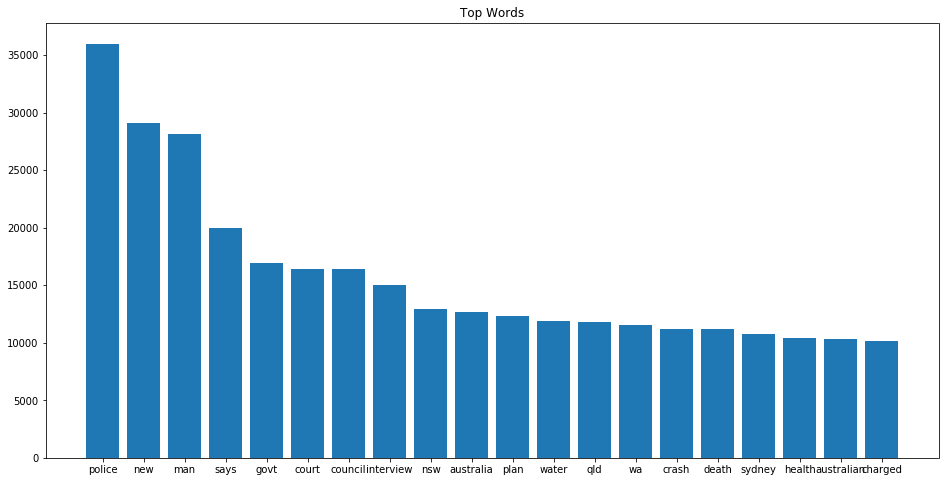

In [2]:
# Define helper functions
# 출현빈도수 상위 n개 추출하는 함수
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    '''returns a tuple of the top n words in a sample and their accompanying counts, given a CountVectorizer object and text sample'''
    vectorized_headlines = count_vectorizer.fit_transform(text_data.as_matrix())
    
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])

from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer(stop_words='english')
words, word_values = get_top_n_words(n_top_words=20, count_vectorizer=count_vectorizer, text_data=reindexed_data)

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values)
ax.set_xticks(range(len(words)))
ax.set_xticklabels(words)
ax.set_title('Top Words')

In [3]:
!pip install textblob
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from textblob import TextBlob

# 단어의 길이 측정하여 저장
# 단어의 품사 검사하여 저장
while True:
    try:
        tagged_headlines = pd.read_csv('abcnews-pos-tagged.csv', index_col=0)
        word_counts = [] 
        pos_counts = {}

        for headline in tagged_headlines[u'tags']:
            headline = ast.literal_eval(headline)
            word_counts.append(len(headline))
            for tag in headline:
                if tag[1] in pos_counts:
                    pos_counts[tag[1]] += 1
                else:
                    pos_counts[tag[1]] = 1

    except IOError:
        tagged_headlines = [TextBlob(reindexed_data[i]).pos_tags for i in range(reindexed_data.shape[0])]

        tagged_headlines = pd.DataFrame({'tags':tagged_headlines})
        tagged_headlines.to_csv('abcnews-pos-tagged.csv')
        continue
    break

print('Total number of words: ', np.sum(word_counts))
print('Mean number of words per headline: ', np.mean(word_counts))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\10User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\10User\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


c:\users\10user\appdata\local\programs\python\python36\lib\site-packages\numpy\lib\arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Total number of words:  7079489
Mean number of words per headline:  6.414527053045988


c:\users\10user\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
c:\users\10user\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  


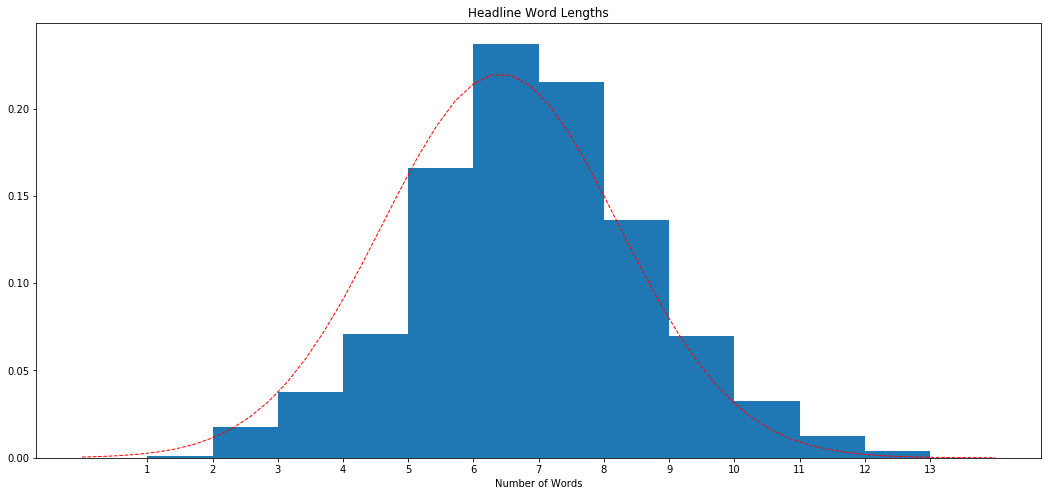

In [4]:
# 단어의 길이 그래프
fig, ax = plt.subplots(figsize=(18,8))
ax.hist(word_counts, bins=range(1,14), normed=1)
ax.set_title('Headline Word Lengths')
ax.set_xticks(range(1,14))
ax.set_xlabel('Number of Words')
y = mlab.normpdf( np.linspace(0,14,50), np.mean(word_counts), np.std(word_counts))
l = ax.plot(np.linspace(0,14,50), y, 'r--', linewidth=1)

Text(0.5,0,'Type of Word')

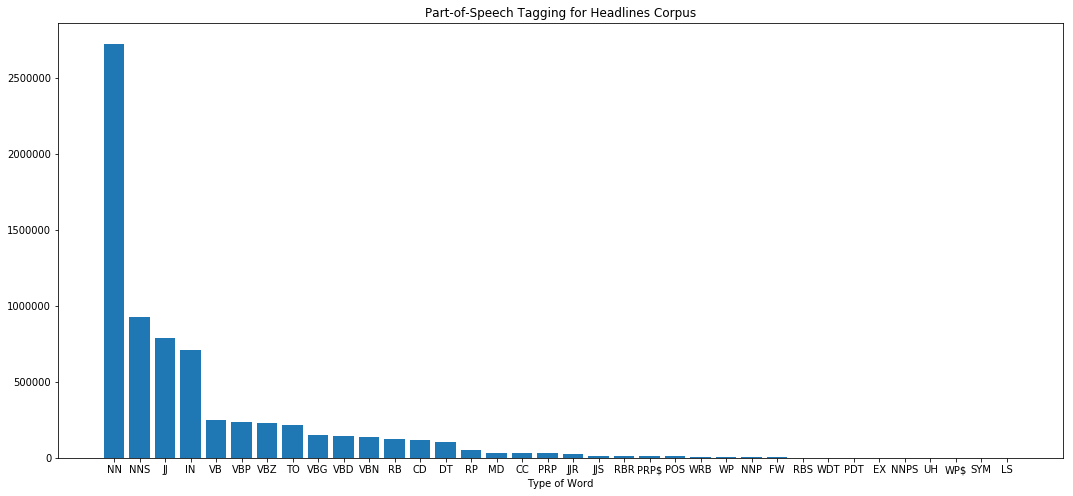

In [5]:
# 단어의 품사 그래프
pos_sorted_types = sorted(pos_counts, key=pos_counts.__getitem__, reverse=True)
pos_sorted_counts = sorted(pos_counts.values(), reverse=True)

fig, ax = plt.subplots(figsize=(18,8))
ax.bar(range(len(pos_counts)), pos_sorted_counts)
ax.set_xticks(range(len(pos_counts)))
ax.set_xticklabels(pos_sorted_types)
ax.set_title('Part-of-Speech Tagging for Headlines Corpus')
ax.set_xlabel('Type of Word')

Text(0.5,1,'Yearly Counts')

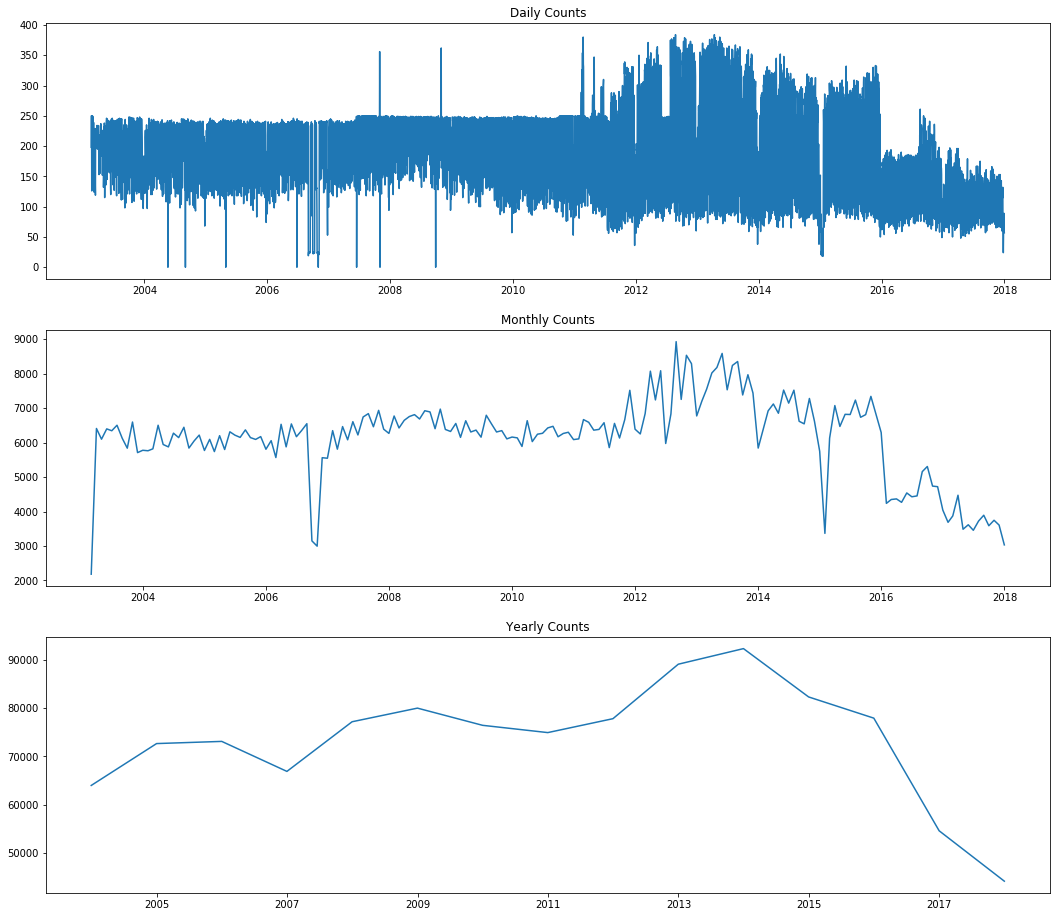

In [6]:
# 기사 년/월/일로 분류 후 개수 세기
monthly_counts = reindexed_data.resample('M').count()
yearly_counts = reindexed_data.resample('A').count()
daily_counts = reindexed_data.resample('D').count()

fig, ax = plt.subplots(3, figsize=(18,16))
ax[0].plot(daily_counts)
ax[0].set_title('Daily Counts')
ax[1].plot(monthly_counts)
ax[1].set_title('Monthly Counts')
ax[2].plot(yearly_counts)
ax[2].set_title('Yearly Counts')

In [7]:
small_count_vectorizer = CountVectorizer(stop_words='english', max_features=40000)
small_text_sample = reindexed_data.sample(n=10000, random_state=0).as_matrix()

print('Headline before vectorization: ', small_text_sample[123])

small_document_term_matrix = small_count_vectorizer.fit_transform(small_text_sample)

print('Headline after vectorization: \n', small_document_term_matrix[123])

c:\users\10user\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Headline before vectorization:  mcewen mp says new labor leadership process will make party mor
Headline after vectorization: 
   (0, 7268)	1
  (0, 8063)	1
  (0, 6740)	1
  (0, 8616)	1
  (0, 7337)	1
  (0, 6925)	1
  (0, 6250)	1
  (0, 7543)	1
  (0, 6365)	1
  (0, 9710)	1


In [8]:
# 8개의 토픽으로 정리하려고 함.
n_topics = 8

# Latent Semantic Analysis

In [9]:
from sklearn.decomposition import TruncatedSVD

lsa_model = TruncatedSVD(n_components=n_topics)
lsa_topic_matrix = lsa_model.fit_transform(small_document_term_matrix)

In [10]:
# Define helper functions
def get_keys(topic_matrix):
    '''returns an integer list of predicted topic categories for a given topic matrix'''
    keys = []
    for i in range(topic_matrix.shape[0]):
        keys.append(topic_matrix[i].argmax())
    return keys

def keys_to_counts(keys):
    '''returns a tuple of topic categories and their accompanying magnitudes for a given list of keys'''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

lsa_keys = get_keys(lsa_topic_matrix)
lsa_categories, lsa_counts = keys_to_counts(lsa_keys)

In [11]:
# Define helper functions
def get_top_n_words(n, keys, document_term_matrix, count_vectorizer):
    '''returns a list of n_topic strings, where each string contains the n most common 
        words in a predicted category, in order'''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = count_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words

top_n_words_lsa = get_top_n_words(10, lsa_keys, small_document_term_matrix, small_count_vectorizer)

for i in range(len(top_n_words_lsa)):
    print("Topic {}: ".format(i), top_n_words_lsa[i])

Topic 0:  police death crash missing probe search years drug year house
Topic 1:  new laws zealand chinese research sets hobart air opens open
Topic 2:  man sydney murder dies charged jailed accused attack guilty car
Topic 3:  says market group power labor iraq day union hospital chief
Topic 4:  govt health qld nsw plan wa water sa school report
Topic 5:  court australian face high faces told sentence case hears decision
Topic 6:  council win gold coast backs plan abc sport bay park
Topic 7:  interview australia world cup england china day final test nrl


Text(0.5,1,'LSA Topic Category Counts')

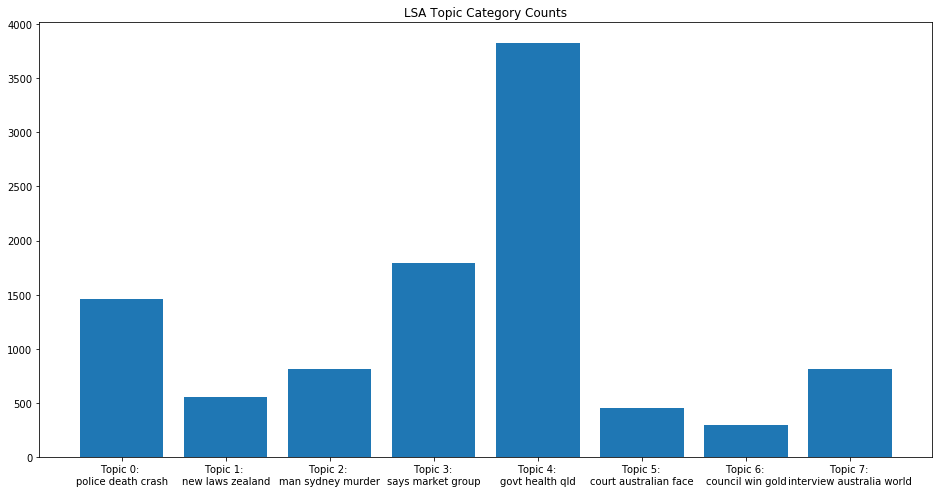

In [12]:
top_3_words = get_top_n_words(3, lsa_keys, small_document_term_matrix, small_count_vectorizer)
labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in lsa_categories]

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(lsa_categories, lsa_counts)
ax.set_xticks(lsa_categories)
ax.set_xticklabels(labels)
ax.set_title('LSA Topic Category Counts')

In [13]:
from sklearn.manifold import TSNE

tsne_lsa_model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                        n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lsa_vectors = tsne_lsa_model.fit_transform(lsa_topic_matrix)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.008s...
[t-SNE] Computed neighbors for 10000 samples in 0.979s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.001902
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.293655
[t-SNE] Error after 2000 iterations: 1.239485


In [14]:
# Define helper functions
def get_mean_topic_vectors(keys, two_dim_vectors):
    '''returns a list of centroid vectors from each predicted topic category'''
    mean_topic_vectors = []
    for t in range(n_topics):
        articles_in_that_topic = []
        for i in range(len(keys)):
            if keys[i] == t:
                articles_in_that_topic.append(two_dim_vectors[i])    
        
        articles_in_that_topic = np.vstack(articles_in_that_topic)
        mean_article_in_that_topic = np.mean(articles_in_that_topic, axis=0)
        mean_topic_vectors.append(mean_article_in_that_topic)
    return mean_topic_vectors

In [15]:
!pip install bokeh
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
output_notebook()

colormap = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c",
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f",
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5" ])
colormap = colormap[:n_topics]

Loading BokehJS ...

In [16]:


top_3_words_lsa = get_top_n_words(3, lsa_keys, small_document_term_matrix, small_count_vectorizer)
lsa_mean_topic_vectors = get_mean_topic_vectors(lsa_keys, tsne_lsa_vectors)

plot = figure(title="t-SNE Clustering of {} LSA Topics".format(n_topics), plot_width=700, plot_height=700)
plot.scatter(x=tsne_lsa_vectors[:,0], y=tsne_lsa_vectors[:,1], color=colormap[lsa_keys])

for t in range(n_topics):
    label = Label(x=lsa_mean_topic_vectors[t][0], y=lsa_mean_topic_vectors[t][1], 
                  text=top_3_words_lsa[t], text_color='#000000')
    plot.add_layout(label)
    
show(plot)

# Latent Dirichilet Allocation

In [17]:
from sklearn.decomposition import LatentDirichletAllocation

lda_model = LatentDirichletAllocation(n_components=n_topics, learning_method='online', 
                                          random_state=0, verbose=0)
lda_topic_matrix = lda_model.fit_transform(small_document_term_matrix)

In [18]:
lda_keys = get_keys(lda_topic_matrix)
lda_categories, lda_counts = keys_to_counts(lda_keys)

In [19]:
top_n_words_lda = get_top_n_words(10, lda_keys, small_document_term_matrix, small_count_vectorizer)

for i in range(len(top_n_words_lda)):
    print("Topic {}: ".format(i), top_n_words_lda[i])

Topic 0:  police new world australia cup day country charges hospital sa
Topic 1:  market farmers murder set power family dead urged fight missing
Topic 2:  health govt new coast gold council rural boost police labor
Topic 3:  says man crash pay police court south claims guilty canberra
Topic 4:  man court plan council sydney qld charged face wins police
Topic 5:  win high centre accused abc public housing darwin review risk
Topic 6:  interview says wa nsw school sex killed iraq child report
Topic 7:  death water australian home new china car action adelaide opposition


Text(0.5,1,'LDA Topic Category Counts')

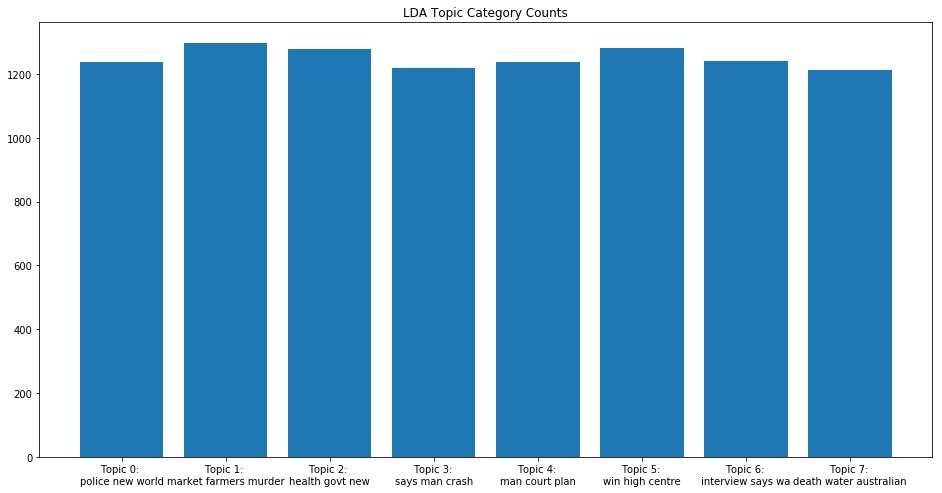

In [20]:
top_3_words = get_top_n_words(3, lda_keys, small_document_term_matrix, small_count_vectorizer)
labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in lda_categories]

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(lda_categories, lda_counts)
ax.set_xticks(lda_categories)
ax.set_xticklabels(labels)
ax.set_title('LDA Topic Category Counts')

In [21]:
from sklearn.manifold import TSNE

tsne_lda_model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                        n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lda_vectors = tsne_lda_model.fit_transform(lda_topic_matrix)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.007s...
[t-SNE] Computed neighbors for 10000 samples in 1.088s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 82.508400
[t-SNE] Error after 2000 iterations: 1.235403


In [22]:
top_3_words_lda = get_top_n_words(3, lda_keys, small_document_term_matrix, small_count_vectorizer)
lda_mean_topic_vectors = get_mean_topic_vectors(lda_keys, tsne_lda_vectors)

plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), plot_width=700, plot_height=700)
plot.scatter(x=tsne_lda_vectors[:,0], y=tsne_lda_vectors[:,1], color=colormap[lda_keys])

for t in range(n_topics):
    label = Label(x=lda_mean_topic_vectors[t][0], y=lda_mean_topic_vectors[t][1], 
                  text=top_3_words_lda[t], text_color='#000000')
    plot.add_layout(label)

show(plot)

# Scaling up

In [23]:
big_sample_size = 100000 

big_count_vectorizer = CountVectorizer(stop_words='english', max_features=40000)
big_text_sample = reindexed_data.sample(n=big_sample_size, random_state=0).as_matrix()
big_document_term_matrix = big_count_vectorizer.fit_transform(big_text_sample)

big_lda_model = LatentDirichletAllocation(n_components=n_topics, learning_method='online', verbose=1)
big_lda_model.fit(big_document_term_matrix)

c:\users\10user\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=8, n_jobs=1, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=1)

In [24]:
yearly_data = []
for i in range(2003,2017+1):
    yearly_data.append(reindexed_data['{}'.format(i)].as_matrix())

yearly_topic_matrices = []
for year in yearly_data:
    document_term_matrix = big_count_vectorizer.transform(year)
    topic_matrix = big_lda_model.transform(document_term_matrix)
    yearly_topic_matrices.append(topic_matrix)

yearly_keys = []
for topic_matrix in yearly_topic_matrices:
    yearly_keys.append(get_keys(topic_matrix))
    
yearly_counts = []
for keys in yearly_keys:
    categories, counts = keys_to_counts(keys)
    yearly_counts.append(counts)

yearly_topic_counts = pd.DataFrame(np.array(yearly_counts), index=range(2003,2017+1))
yearly_topic_counts.columns = ['Topic {}'.format(i) for i in range(n_topics)]

print(yearly_topic_counts)

c:\users\10user\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


      Topic 0  Topic 1  Topic 2  Topic 3  Topic 4  Topic 5  Topic 6  Topic 7
2003     9531     7865     7051     7724     8750     7595     8186     7301
2004     8823    11696     9288     8811     7883     8303     9454     8416
2005    11372     9682     8828     9762     9547     7859     8125     7949
2006     8874     8674     7629     8069     6952     8803    10449     7462
2007     9062    12325     8323    10355     9895     8674     9800     8758
2008    12078     9262     9604    10816     9389    10005     9683     9178
2009     8729     9087     9487     9348     9664    11388     8956     9795
2010    10261     9416    10257     9526     9260     8497     9035     8696
2011     9513    10110     9432     9715     8995    10479     9398    10187
2012    11169    11069    11978    10779    10093    10721    11997    11303
2013    12538    11541    11709    12578    10606     9533    11910    11922
2014    11122    11018     9294     9911    11932    10672     8965     9416

In [25]:
complete_keys = [key for year in yearly_keys for key in year]
complete_topic_matrix = np.vstack(yearly_topic_matrices)
complete_document_term_matrix = big_count_vectorizer.transform(reindexed_data.as_matrix())

top_n_words = get_top_n_words(10, complete_keys, complete_document_term_matrix, big_count_vectorizer)

for i in range(len(top_n_words)):
    print('Topic {}: '.format(i), top_n_words[i])

c:\users\10user\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


Topic 0:  australian new country sa hour home year guilty search continues
Topic 1:  police council plan qld coast health new court gold boost
Topic 2:  death crash court government win school drug police power ban
Topic 3:  sydney south west adelaide case lead wa future jail return
Topic 4:  interview nsw report calls murder trial iraq north inquiry rise
Topic 5:  man govt charged australia water cup world accused dies melbourne
Topic 6:  new market day rural hospital wins national open set final
Topic 7:  says urged farmers car fears help change plans house claims


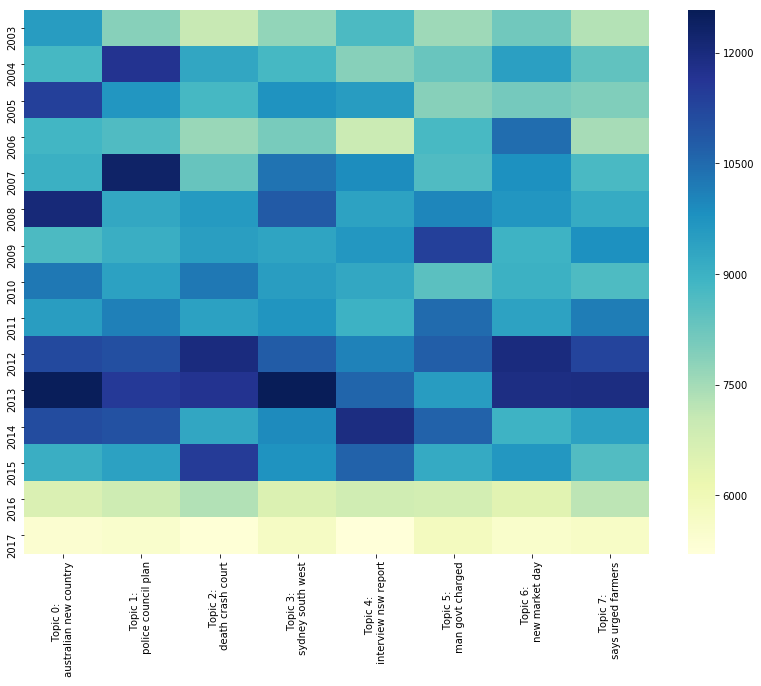

In [27]:
labels = ['Topic {}: \n '.format(i) + ' '.join([topic.split() for topic in top_n_words][i][:3]) for i in range(n_topics)]

fig, ax = plt.subplots(figsize=(14,10))
sb.heatmap(yearly_topic_counts, xticklabels=labels, cmap="YlGnBu", ax=ax)